# Intramarket Differencing

- https://www.youtube.com/watch?v=n2mY86S01fg
- python colab https://colab.research.google.com/drive/17hNO_Z5bF3d6iZrIFd4aw1utBGDORUWX#scrollTo=cv00kwIw1N6s


In [ ]:
library(readr)
library(dplyr)
library(TTR)
library(ggplot2)
library(lubridate)
library(zoo) # rollmean

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7, warn=-1)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

In [3]:
# Read CSV file
df <- read_csv("neurotrader888/IntramarketDifference/bybit_prices_2017-2024.csv")

Rows: 822969 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): symbol
dbl  (6): open, high, low, close, volume, turnover
dttm (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Correlation

In [92]:
main_symbol <- "BTCUSDT"       # The other symbol to compare against
other_symbol <- "ETHUSDT"  # Example symbol

# Assuming df is already loaded and manipulated as per your code
data <- df %>%
  filter(symbol %in% c(main_symbol, other_symbol),
         date >= as.POSIXct("2021-03-15 00:00:00", tz = "UTC")) %>%
  group_by(symbol) %>%
  mutate(diff = log(close) - lag(log(close))) %>%
  ungroup() # Ensure data is not grouped for further operations

# Separate data for BTC and ETH
btc_diff <- data %>% filter(symbol == main_symbol) %>% select(date, diff) %>% na.omit()
eth_diff <- data %>% filter(symbol == other_symbol) %>% select(date, diff) %>% na.omit()

# Aligning the dates might be necessary if the trading dates do not completely overlap
# This code assumes dates are aligned. If they are not, you'd need to join by date before computing correlation
correlation <- cor(btc_diff$diff, eth_diff$diff)

print(paste("Correlation:", correlation))

[1] "Correlation: 0.863871982990826"


# Chart Two Symbols

[1] 58023.7
[1] 3947.95


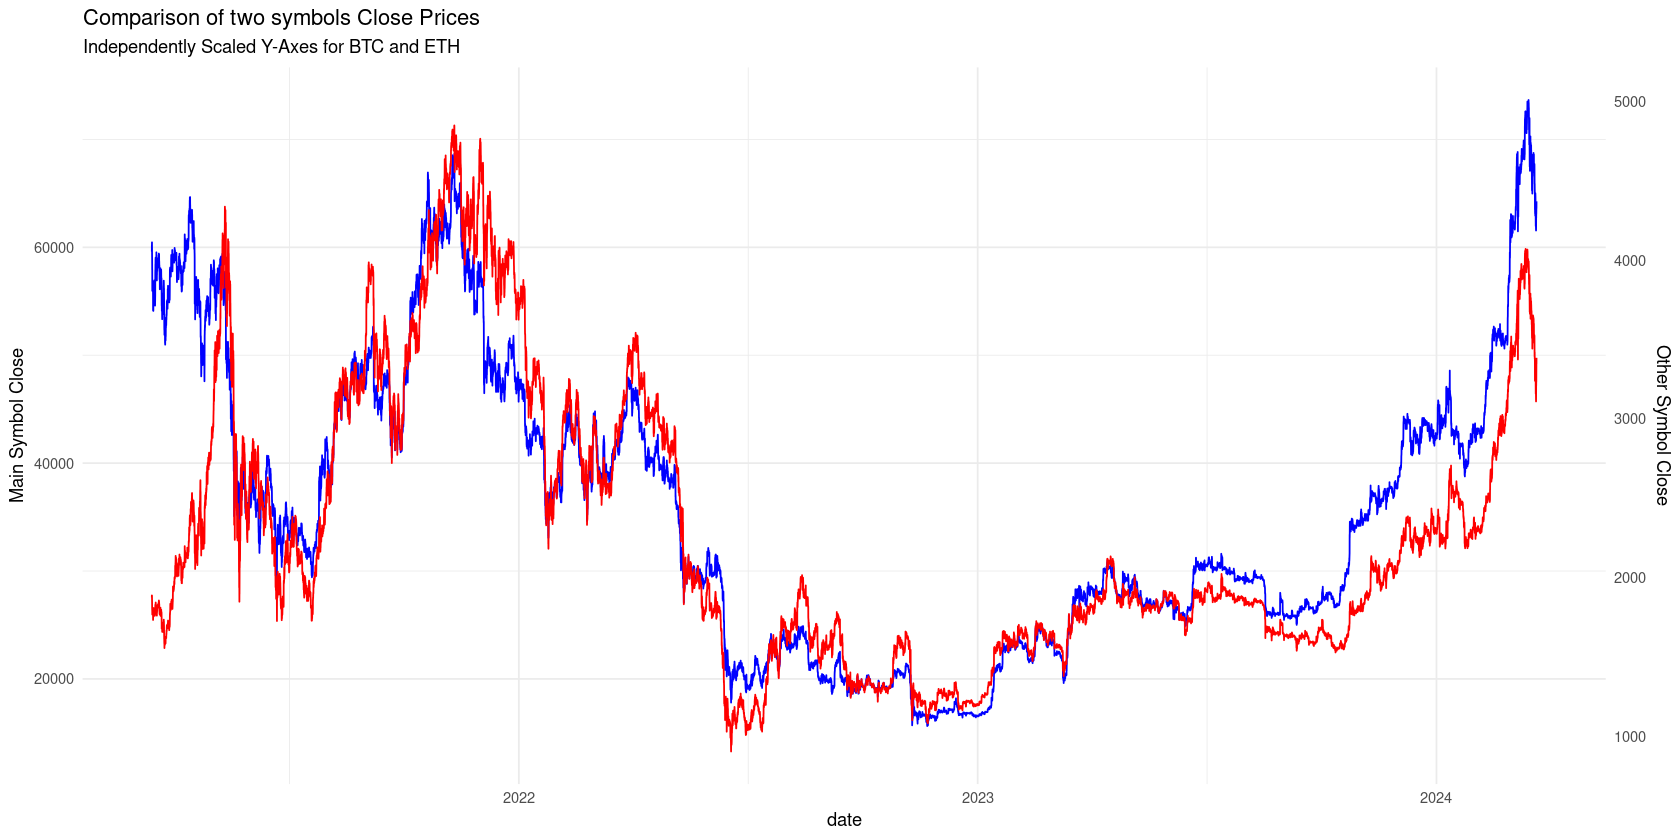

In [72]:
# Compute the scaling factor outside of the chain
btc_range <- data %>%
  filter(symbol == main_symbol) %>%
  summarize(range = max(close) - min(close)) %>%
  pull(range)

eth_range <- data %>%
  filter(symbol == other_symbol) %>%
  summarize(range = max(close) - min(close)) %>%
  pull(range)

print(btc_range)
print(eth_range)

scaling_factor <- btc_range / eth_range

# Now we pipe the data frame into ggplot in a single chain
df %>%
  # Filter out data to only include BTC and ETH from a certain date
  filter(symbol %in% c(main_symbol, other_symbol), date >= as.Date("2021-03-15")) %>%
  # Plot
  ggplot(aes(x = date)) +
  geom_line(data = . %>% filter(symbol == main_symbol), aes(y = close), color = "blue") +
  geom_line(data = . %>% filter(symbol == other_symbol), aes(y = close * scaling_factor), color = "red") +
  scale_y_continuous(
    name = "Main Symbol Close",
    sec.axis = sec_axis(~ . / scaling_factor, name = "Other Symbol Close")
  ) +
  theme_minimal() +
  ggtitle('Comparison of two symbols Close Prices', subtitle = 'Independently Scaled Y-Axes for BTC and ETH')

In [84]:
lookback <- 24  # Period for moving average
atr_lookback <- 168  # Period for ATR
threshold <- 0.25

main_symbol <- "BTCUSDT"       # The other symbol to compare against
other_symbol <- "DOGEUSDT"  # Example symbol

library(roll)

# cmma values
cmma <- df %>%
  filter(symbol %in% c(main_symbol, other_symbol), date >= as.Date("2021-03-15")) %>%
  arrange(symbol, date) %>%  # Ensure data is sorted
  group_by(symbol) %>%
#   arrange(date) %>%
  mutate(
    # Calculate the moving average using rollmean from the zoo package
    moving_avg = rollmean(close, lookback, fill = NA, align = 'right'),
    # Calculate True Range (TR)
    tr = pmax(high - low, abs(high - lag(close)), abs(low - lag(close)), na.rm = TRUE),
    # Calculate the ATR using rollmean on the TR
    atr = rollmean(tr, atr_lookback, fill = NA, align = 'right'),
    # Calculate the new indicator (ind)
    ind = (close - moving_avg) / (atr * sqrt(lookback)),
    # diff = log(close) - lag(log(close)),
    # next_return = lead(diff),
    log_return = log(close / lag(close, n = 1)),
    next_log_return = lead(log_return)
  ) %>%
  na.omit() %>%
  ungroup()  # Ungroup for further operations
# cmma
head(cmma)

date,symbol,open,high,low,close,volume,turnover,moving_avg,tr,atr,ind,log_return,next_log_return
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-03-21 23:00:00,BTCUSDT,57646.5,57795.5,57197.0,57351.0,752.477,43155308,57265.75,598.5,682.3274,0.02550328,-0.0051392535,-0.0122276862
2021-03-22 00:00:00,BTCUSDT,57351.0,57426.0,56519.0,56654.0,1653.691,93688210,57194.46,907.0,680.7113,-0.16206664,-0.0122276862,0.0004852848
2021-03-22 01:00:00,BTCUSDT,56654.0,56778.5,56378.5,56681.5,741.243,42014765,57129.12,400.0,677.6786,-0.13482951,0.0004852848,0.0054279350
2021-03-22 02:00:00,BTCUSDT,56681.5,57072.0,56520.0,56990.0,616.244,35119746,57098.73,552.0,679.4762,-0.03266376,0.0054279350,0.0103428882
2021-03-22 03:00:00,BTCUSDT,56990.0,57625.0,56990.0,57582.5,996.850,57401115,57085.92,635.0,681.1429,0.14881555,0.0103428882,0.0004861407
2021-03-22 04:00:00,BTCUSDT,57582.5,57816.5,57453.0,57610.5,602.175,34691603,57110.12,363.5,677.9613,0.15065553,0.0004861407,0.0002863651


In [85]:
library(dplyr)
library(tidyr)


# Assuming cmma is your dataset with the 'symbol' and 'ind' columns prepared
cmma_wide <- cmma %>%
# group_by(date, symbol) %>%
  pivot_wider(
    date,
    names_from = symbol,    # Use 'symbol' as the source of column names
    values_from = ind       # Spread the 'ind' values across those new columns
  ) %>%
  mutate(
    # ind_diff = ETHUSDT - BTCUSDT # Calculate the difference between BTCUSDT and ETHUSDT
    ind_diff = .data[[other_symbol]] - .data[[main_symbol]]
  ) %>%
  arrange(date)

head(cmma_wide)

# The cmma_wide dataset now has separate columns for each symbol's 'ind' values,
# plus a new 'ind_diff' column for their difference

date,BTCUSDT,DOGEUSDT,ind_diff
<dttm>,<dbl>,<dbl>,<dbl>
2021-03-21 23:00:00,0.02550328,NA,NA
2021-03-22 00:00:00,-0.16206664,NA,NA
2021-03-22 01:00:00,-0.13482951,NA,NA
2021-03-22 02:00:00,-0.03266376,NA,NA
2021-03-22 03:00:00,0.14881555,NA,NA
2021-03-22 04:00:00,0.15065553,NA,NA


In [86]:
# join ind_diff column to cmma
intermarket_diff <- cmma %>%
  filter(symbol == other_symbol) %>%
#   inner_join(select(cmma_wide, date, ind_diff = .data[[predefined_symbol]]), by = "date") %>%
  inner_join(select(cmma_wide, date, ind_diff), by = "date")

head(intermarket_diff)

date,symbol,open,high,low,close,volume,turnover,moving_avg,tr,atr,ind,log_return,next_log_return,ind_diff
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-06-09 09:00:00,DOGEUSDT,0.3222,0.3255,0.3215,0.3218,6402283,2071949,0.3227792,0.0040,0.010232738,-0.01953256,-0.001242236,0.011432227,-0.4214671
2021-06-09 10:00:00,DOGEUSDT,0.3218,0.3267,0.3206,0.3255,4778478,1546825,0.3227792,0.0061,0.010202976,0.05443390,0.011432227,0.009478744,-0.5134709
2021-06-09 11:00:00,DOGEUSDT,0.3255,0.3300,0.3241,0.3286,4659572,1525807,0.3226417,0.0059,0.010098810,0.12043397,0.009478744,0.001520450,-0.6077428
2021-06-09 12:00:00,DOGEUSDT,0.3286,0.3354,0.3280,0.3291,10824314,3587957,0.3227167,0.0074,0.010064881,0.12945930,0.001520450,-0.003957990,-0.5495607
2021-06-09 13:00:00,DOGEUSDT,0.3291,0.3305,0.3255,0.3278,7286574,2385173,0.3230167,0.0050,0.009947619,0.09815352,-0.003957990,-0.020028400,-0.6135419
2021-06-09 14:00:00,DOGEUSDT,0.3278,0.3297,0.3192,0.3213,10471852,3408528,0.3235958,0.0105,0.009882143,-0.04742241,-0.020028400,0.033963797,-0.5385368


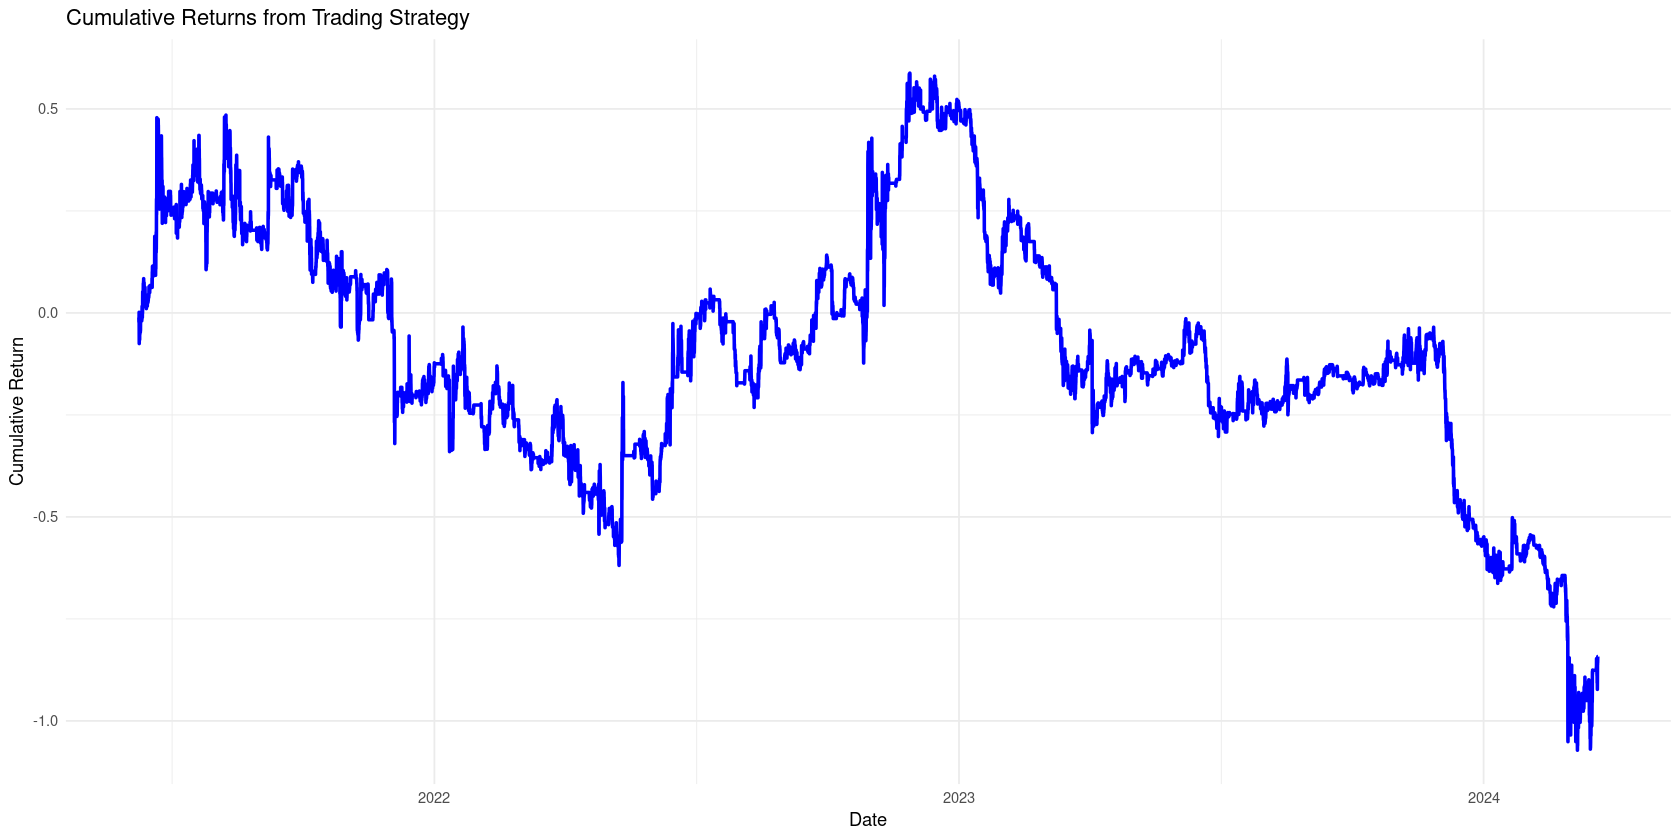

In [94]:
library(dplyr)
library(purrr)

# Define the function to calculate positions based on ind_diff and a threshold
calculate_positions <- function(ind_diff, threshold) {
  position <- numeric(length(ind_diff)) # Initialize the position vector
  current_position <- 0 # Initialize the current position

  for (i in seq_along(ind_diff)) {
    if (ind_diff[i] > threshold) {
      current_position <- 1
    } else if (ind_diff[i] < -threshold) {
      current_position <- -1
    #   current_position <- 0
    } else if ((current_position == 1 && ind_diff[i] <= 0) || (current_position == -1 && ind_diff[i] >= 0)) {
      current_position <- 0
    }
    position[i] <- current_position
  }

  return(position)
}

# Assuming eth_data_with_diff is your dataframe after joining with cmma_wide and it has an 'ind_diff' column
threshold <- 0.25 # Define your threshold
# threshold <- 0.10 # Define your threshold

intermarket_diff <- intermarket_diff %>%
  mutate(position = calculate_positions(ind_diff, threshold)) %>%
#   mutate(position = case_when(
#     ind_diff > threshold ~ 1,
#     ind_diff < -threshold ~ -1,
#     TRUE ~ 0
#   ))%>%
  mutate(
    rets = position * next_log_return,
    rets_cumsum = cumsum(rets)
  )
# # Adjusting for the position logic as per the Python example, considering previous values
# eth_data_with_diff_and_position <- eth_data_with_diff_and_position %>%
#   mutate(position = ifelse(lag(ind_diff) <= 0 & ind_diff > 0, 0,
#                            ifelse(lag(ind_diff) >= 0 & ind_diff < 0, 0, position)))

# Viewing the first few rows of the dataframe with the new 'position' column
# (intermarket_diff)
# head(intermarket_diff)

ggplot(intermarket_diff, aes(x = date, y = rets_cumsum)) +
#   geom_line() +
  geom_line(color = "blue", size = 1) +  # Draw the line for cumulative returns
  theme_minimal() +
  labs(title = "Cumulative Returns from Trading Strategy",
       x = "Date",
       y = "Cumulative Return")
